In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

### Load the data

In [2]:
data = pd.read_json('train.json')
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Create a binary matrix indicating whether or not an ingredient is in a recipe

In [3]:
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LDA

#### Try NComponents = 6

In [ ]:
NComponents = 6

In [7]:
%%time
lda = LatentDirichletAllocation(n_components = NComponents)
lda.fit(dataBinaryIngredients.values)

CPU times: user 2min 5s, sys: 1.39 s, total: 2min 6s
Wall time: 2min 7s


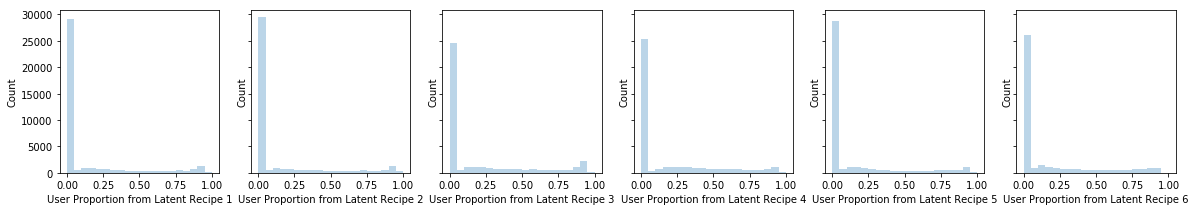

In [15]:
recipeProportionsfromLatentRecipes = lda.transform(dataBinaryIngredients.values)

fig, axes = plt.subplots(1, NComponents, figsize=(20,3), sharey=True)
for i in range(NComponents):
    ax = axes[i]
    ax.hist(recipeProportionsfromLatentRecipes[:, i], alpha=0.3, range=(0,1), bins=20)
    ax.set_xlabel('Recipe Proportion from Latent Recipe '+str(i+1))
    ax.set_ylabel('Count')
plt.show()

N component = 6


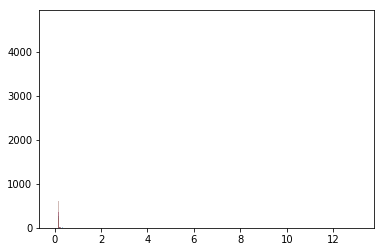

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'jalapeno chilies' 'ground cumin' 'sour cream' 'chili powder'
 'avocado' 'chopped cilantro fresh']
Latent recipe 2 : ['salt' 'onions' 'water' 'garlic' 'fish sauce' 'vegetable oil'
 'garlic cloves']
Latent recipe 3 : ['olive oil' 'salt' 'garlic cloves' 'extra-virgin olive oil'
 'ground black pepper' 'fresh lemon juice' 'dry white wine']
Latent recipe 4 : ['salt' 'onions' 'garlic' 'olive oil' 'pepper' 'water'
 'ground black pepper']
Latent recipe 5 : ['soy sauce' 'sugar' 'corn starch' 'sesame oil' 'water' 'salt'
 'green onions']
Latent recipe 6 : ['salt' 'all-purpose flour' 'sugar' 'butter' 'milk' 'large eggs' 'eggs']


In [23]:
latentRecipes = lda.components_

print('N component =', NComponents)

# top ingredients for each "latent recipe"
print('Top ingredients for each "latent recipe":')
for i in range(NComponents):
    topIndices = np.where((latentRecipes[i,:] > np.percentile(latentRecipes[i,:], 99.9))&(latentRecipes[i,:] > 0.1))[0]
    topIndices = topIndices[np.argsort(-latentRecipes[i, topIndices])]
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices]) #, latentRecipes[i, topIndices]


### Similarity matrix between latent recipes and cuisines

In [19]:
cuisineList = data['cuisine'].unique()
ingredientBag = [ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']]

# ingredient count (in total and in each cuisine)
count = []
count.append(dict(Counter(ingredientBag)))
for cuisine in cuisineList:
    dataCuisine = data[data['cuisine']==cuisine].copy().reset_index()
    count.append(dict(Counter([ingredient for i in range(dataCuisine.shape[0]) for ingredient in dataCuisine.loc[i,'ingredients']])))
ingredientCount = pd.DataFrame(count).T
ingredientCount.columns = ['total'] + [cuisine for cuisine in cuisineList]
ingredientCount = ingredientCount.fillna(0)

# the frequency of an ingredient in each cuisine (proportion of recipes with this ingredient for a cuisine)
ingredientFrequency = ingredientCount[[cuisine for cuisine in cuisineList]].div(data['cuisine'].value_counts()[cuisine], axis=1)

# transpose to be consistent with W
cuisineIngredientFrequency = ingredientFrequency.T[ingredientList]

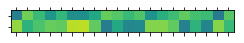

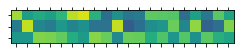

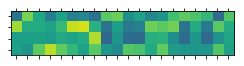

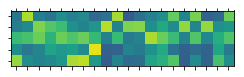

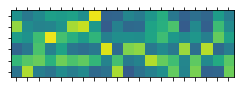

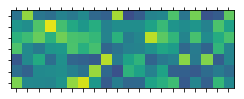

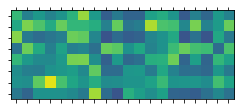

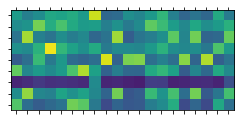

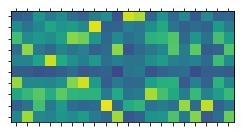

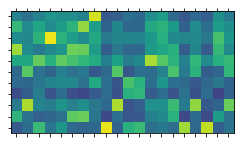

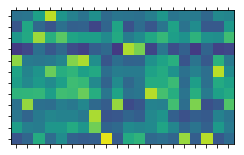

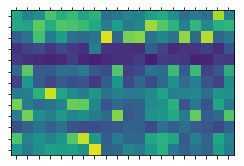

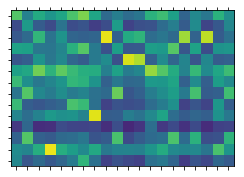

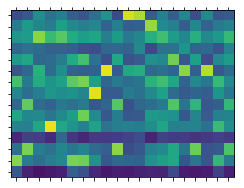

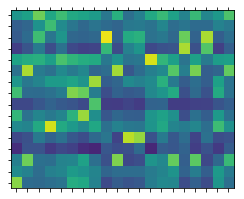

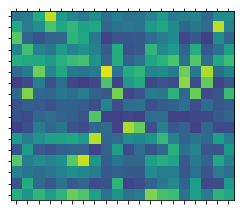

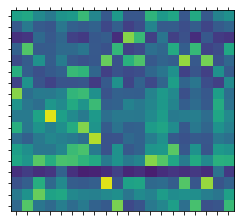

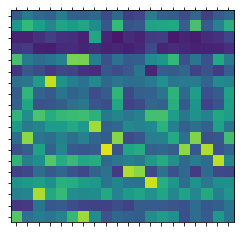

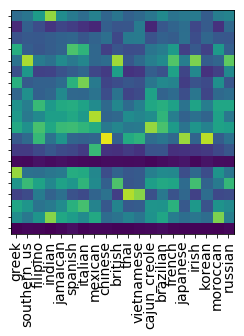

In [20]:
NComponentsMax = 20
corrmatList = []

for NComponents in np.arange(1,NComponentsMax)+1:

    # load in LDA results
    latentRecipes = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_latentRecipes.csv', header=None, index_col=False).values # pseudo counts
    
    # calculate correlations between cuisines and latent recipes
    NCuisine = len(cuisineList)
    corrmatList.append(np.zeros((NComponents, NCuisine)))
    for iLatentRecipe in range(NComponents):
        for iCuisine in range(NCuisine):
            corrmatList[-1][iLatentRecipe, iCuisine] = np.corrcoef(cuisineIngredientFrequency.values[iCuisine,:],latentRecipes[iLatentRecipe,:])[0,1]
    
    # plot the correlations
    fig, ax = plt.subplots(figsize=(4,NComponents/2))
    p = ax.matshow(corrmatList[-1], vmin=0, vmax=1)
    ax.set(xticks=range(NCuisine), yticks=range(NComponents), xticklabels=[], yticklabels=[])

ax.set_xticks(range(NCuisine))
ax.set_xticklabels(labels=cuisineList, rotation=90, fontsize=14)
ax.xaxis.tick_bottom()
plt.show()

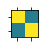

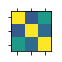

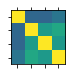

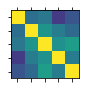

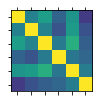

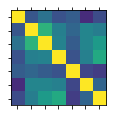

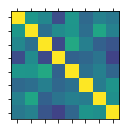

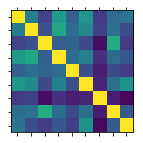

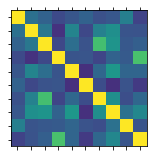

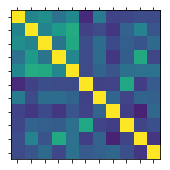

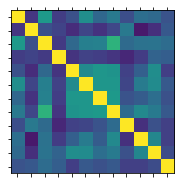

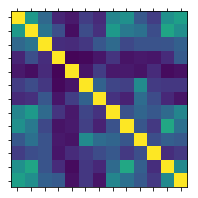

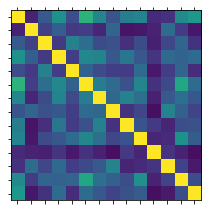

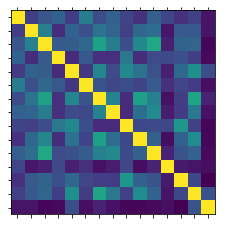

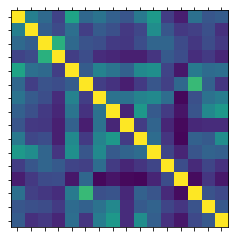

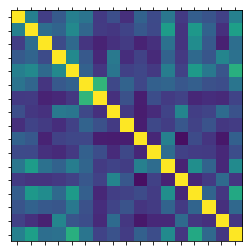

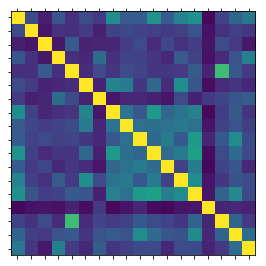

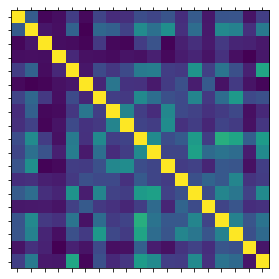

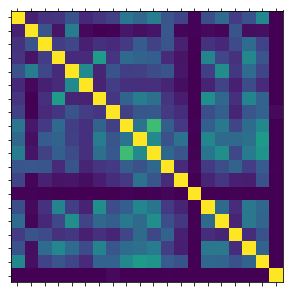

In [24]:
# similarity between latent recipes
NComponentsMax = 20
corrmatList = []

for NComponents in np.arange(1,NComponentsMax)+1:

    # load in LDA results
    latentRecipes = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_latentRecipes.csv', header=None, index_col=False).values # pseudo counts
    
    # plot the correlations
    fig, ax = plt.subplots(figsize=(NComponents/4,NComponents/4))
    p = ax.matshow(np.corrcoef(latentRecipes), vmin=0, vmax=1)
    ax.set(xticks=range(NComponents), yticks=range(NComponents), xticklabels=[], yticklabels=[])

plt.show()

### Supplementary: LDA with various number of "latent recipes"

In [ ]:
# run LDA with different values of NComponents
for NComponents in np.arange(1,20)+1:
    lda = LatentDirichletAllocation(n_components=NComponents, max_iter=100)
    lda.fit(dataBinaryIngredients.values)
    latentRecipes = lda.components_
    recipeProportionsfromLatentRecipes = lda.transform(dataBinaryIngredients.values)
    pd.DataFrame(latentRecipes).to_csv('LDAresults/NComponents'+str(NComponents)+'_latentRecipes.csv', header=False, index=False) # beta
    pd.DataFrame(recipeProportionsfromLatentRecipes).to_csv('LDAresults/NComponents'+str(NComponents)+'_recipeProportionsfromLatentRecipes.csv', header=False, index=False) # theta

N component = 2


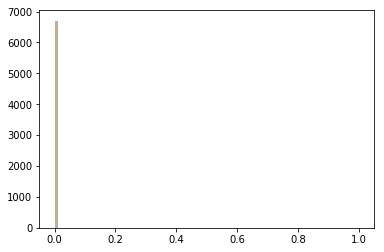

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'sugar' 'water' 'all-purpose flour' 'soy sauce' 'vegetable oil'
 'eggs'] [0.03566515 0.03369401 0.02071176 0.01745363 0.01726221 0.01516591
 0.01347453]
Latent recipe 2 : ['salt' 'olive oil' 'onions' 'garlic cloves' 'garlic'
 'ground black pepper' 'pepper'] [0.04605851 0.0326695  0.03266441 0.02145702 0.02047677 0.01960648
 0.01632819]

N component = 3


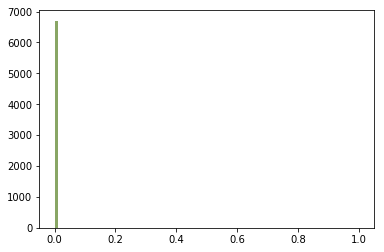

Top ingredients for each "latent recipe":
Latent recipe 1 : ['olive oil' 'salt' 'garlic cloves' 'onions' 'ground black pepper'
 'garlic' 'extra-virgin olive oil'] [0.04563608 0.04318419 0.0260938  0.02549495 0.02428072 0.01937673
 0.01820988]
Latent recipe 2 : ['salt' 'all-purpose flour' 'sugar' 'butter' 'eggs' 'large eggs' 'milk'] [0.05551387 0.0488424  0.0427772  0.0359097  0.02936759 0.02932858
 0.02386409]
Latent recipe 3 : ['salt' 'garlic' 'onions' 'water' 'soy sauce' 'vegetable oil'
 'ground cumin'] [0.03312423 0.02355206 0.02180277 0.01982015 0.01741747 0.01649387
 0.01451627]

N component = 4


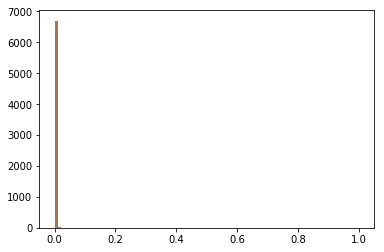

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'salt' 'soy sauce' 'all-purpose flour' 'water' 'eggs'
 'large eggs'] [0.04914367 0.04202084 0.02918195 0.02849588 0.02317649 0.01945274
 0.01785436]
Latent recipe 2 : ['salt' 'olive oil' 'garlic cloves' 'ground black pepper' 'onions'
 'extra-virgin olive oil' 'garlic'] [0.04488237 0.04307185 0.0291334  0.025137   0.02254376 0.01989428
 0.01840038]
Latent recipe 3 : ['salt' 'onions' 'pepper' 'sour cream' 'garlic powder' 'chili powder'
 'avocado'] [0.03674035 0.0213831  0.02125375 0.01964686 0.01842071 0.01644789
 0.01568737]
Latent recipe 4 : ['salt' 'onions' 'garlic' 'water' 'garlic cloves' 'ground cumin'
 'chopped cilantro fresh'] [0.04003043 0.0301588  0.02642139 0.02097142 0.01886572 0.01666038
 0.01607776]

N component = 5


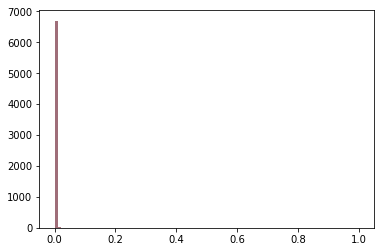

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'salt' 'all-purpose flour' 'large eggs' 'butter'
 'unsalted butter' 'baking powder'] [0.0582447  0.05369325 0.04854595 0.03042768 0.03009714 0.02724148
 0.02502616]
Latent recipe 2 : ['salt' 'soy sauce' 'water' 'garlic' 'sugar' 'vegetable oil' 'onions'] [0.0305608  0.02901552 0.02422881 0.02381059 0.02102966 0.01789695
 0.01771934]
Latent recipe 3 : ['salt' 'onions' 'pepper' 'garlic' 'butter' 'olive oil' 'water'] [0.05330778 0.04109583 0.02945266 0.02760295 0.02397493 0.02016671
 0.01930138]
Latent recipe 4 : ['salt' 'ground cumin' 'jalapeno chilies' 'chili powder'
 'chopped cilantro fresh' 'olive oil' 'sour cream'] [0.03462916 0.03355842 0.02520126 0.0229412  0.01947403 0.01858993
 0.0183637 ]
Latent recipe 5 : ['olive oil' 'salt' 'garlic cloves' 'extra-virgin olive oil'
 'ground black pepper' 'fresh lemon juice' 'kosher salt'] [0.0519462  0.03955424 0.03529916 0.02910417 0.0246711  0.0145737
 0.0138798 ]

N componen

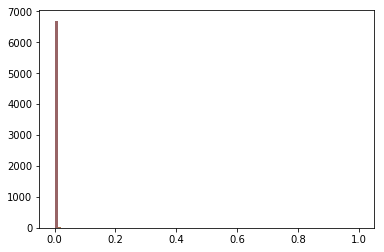

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'jalapeno chilies' 'ground cumin' 'chili powder' 'avocado'
 'sour cream' 'onions'] [0.03496704 0.0261417  0.0237236  0.02272675 0.01954554 0.0193654
 0.01901491]
Latent recipe 2 : ['olive oil' 'salt' 'garlic cloves' 'extra-virgin olive oil'
 'ground black pepper' 'fresh lemon juice' 'dry white wine'] [0.05610339 0.04010127 0.03471363 0.03127193 0.02506747 0.0142286
 0.01386679]
Latent recipe 3 : ['salt' 'onions' 'water' 'ground cumin' 'garlic' 'ground turmeric'
 'cumin seed'] [0.04670196 0.03572404 0.02199247 0.02123604 0.0204349  0.0160401
 0.0158035 ]
Latent recipe 4 : ['soy sauce' 'sugar' 'garlic' 'water' 'sesame oil' 'salt' 'green onions'] [0.04205827 0.02870283 0.02471027 0.02327469 0.02262517 0.02165638
 0.02015821]
Latent recipe 5 : ['salt' 'onions' 'pepper' 'butter' 'garlic' 'water' 'ground black pepper'] [0.05296355 0.0383505  0.02841298 0.02348484 0.02288048 0.02046726
 0.01739586]
Latent recipe 6 : ['sugar' 

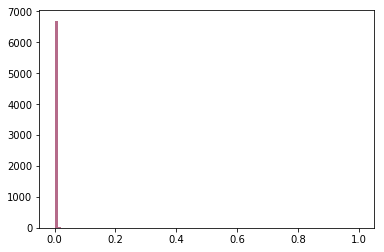

Top ingredients for each "latent recipe":
Latent recipe 1 : ['all-purpose flour' 'salt' 'butter' 'sugar' 'milk' 'large eggs'
 'unsalted butter'] [0.08531045 0.07917325 0.05535508 0.05025662 0.05018039 0.04997683
 0.04699372]
Latent recipe 2 : ['salt' 'onions' 'garlic' 'water' 'oil' 'ground cumin' 'ground turmeric'] [0.04809885 0.04196562 0.02523162 0.02457532 0.02369228 0.01794211
 0.01654131]
Latent recipe 3 : ['salt' 'onions' 'pepper' 'garlic' 'water' 'ground black pepper' 'butter'] [0.05080301 0.04627996 0.02939136 0.0225179  0.02165929 0.02024235
 0.01942685]
Latent recipe 4 : ['salt' 'garlic cloves' 'olive oil' 'chopped cilantro fresh'
 'purple onion' 'ground cumin' 'fresh lime juice'] [0.04471381 0.03175336 0.02714285 0.02381081 0.02338935 0.02205069
 0.02080238]
Latent recipe 5 : ['sugar' 'soy sauce' 'water' 'sesame oil' 'salt' 'corn starch' 'scallions'] [0.04332621 0.04274197 0.02583344 0.02299282 0.0217827  0.02085463
 0.01701413]
Latent recipe 6 : ['lime' 'garlic' 'fish sauce

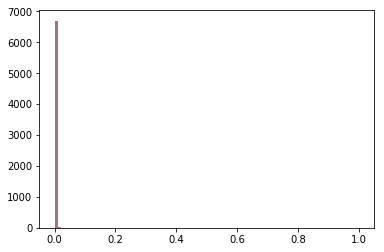

Top ingredients for each "latent recipe":
Latent recipe 1 : ['olive oil' 'grated parmesan cheese' 'salt' 'garlic' 'pepper' 'onions'
 'dried oregano'] [0.05622274 0.04295428 0.04187872 0.04163889 0.02638499 0.02445953
 0.01926356]
Latent recipe 2 : ['salt' 'onions' 'butter' 'pepper' 'all-purpose flour' 'eggs'
 'ground black pepper'] [0.0600508  0.03406605 0.0317822  0.03066979 0.02113836 0.01985844
 0.01950831]
Latent recipe 3 : ['extra-virgin olive oil' 'salt' 'olive oil' 'garlic cloves'
 'fresh lemon juice' 'ground black pepper' 'cooking spray'] [0.0520514  0.04524631 0.04113407 0.03883535 0.02944717 0.02795091
 0.02015159]
Latent recipe 4 : ['sugar' 'salt' 'soy sauce' 'all-purpose flour' 'water' 'large eggs'
 'sesame oil'] [0.05208485 0.04191444 0.03089046 0.02727914 0.02409433 0.01860448
 0.01814154]
Latent recipe 5 : ['olive oil' 'garlic cloves' 'salt' 'dry white wine' 'onions'
 'unsalted butter' 'ground black pepper'] [0.04546771 0.03528099 0.03269677 0.02609606 0.02503035 0.02444

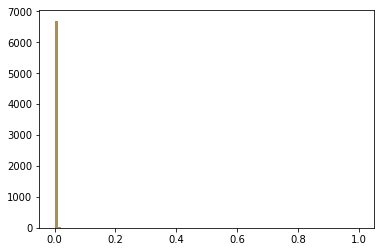

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'jalapeno chilies' 'ground cumin' 'chili powder' 'olive oil'
 'garlic' 'chopped cilantro fresh'] [0.04604476 0.03403838 0.03258833 0.0285088  0.02720416 0.02462195
 0.02372851]
Latent recipe 2 : ['onions' 'salt' 'water' 'carrots' 'garlic' 'pepper' 'bay leaves'] [0.07078117 0.04890687 0.03864583 0.03688541 0.03080131 0.02527991
 0.0198365 ]
Latent recipe 3 : ['sugar' 'salt' 'all-purpose flour' 'baking powder' 'butter'
 'unsalted butter' 'large eggs'] [0.06272601 0.05419664 0.04430464 0.02947451 0.02883961 0.02745909
 0.02444742]
Latent recipe 4 : ['salt' 'onions' 'ground cumin' 'water' 'ground turmeric' 'garlic'
 'cumin seed'] [0.04795166 0.03695525 0.02274748 0.02074259 0.01979244 0.01968656
 0.01950049]
Latent recipe 5 : ['soy sauce' 'sugar' 'garlic' 'sesame oil' 'water' 'green onions' 'salt'] [0.04736344 0.03007023 0.02578318 0.02547871 0.02191764 0.02146784
 0.01973877]
Latent recipe 6 : ['olive oil' 'salt' 'garlic'

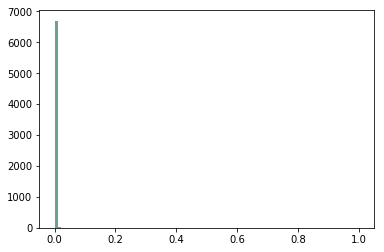

Top ingredients for each "latent recipe":
Latent recipe 1 : ['fish sauce' 'sugar' 'lime' 'coconut milk' 'garlic' 'vegetable oil'
 'water'] [0.03859042 0.02253492 0.02195236 0.0209932  0.01991358 0.01768975
 0.0168615 ]
Latent recipe 2 : ['salt' 'ground cumin' 'jalapeno chilies' 'chili powder' 'sour cream'
 'avocado' 'onions'] [0.03572291 0.02595354 0.02524321 0.02523549 0.02080281 0.0206325
 0.02057923]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'salt' 'onions' 'ground black pepper'
 'carrots' 'kosher salt'] [0.04316916 0.03739283 0.02956887 0.028373   0.02526079 0.02521549
 0.01948085]
Latent recipe 4 : ['sugar' 'salt' 'all-purpose flour' 'butter' 'unsalted butter'
 'vanilla extract' 'large eggs'] [0.05846758 0.04536412 0.03767924 0.03339037 0.02963502 0.02874652
 0.02505984]
Latent recipe 5 : ['salt' 'onions' 'ground cumin' 'ground turmeric' 'cumin seed'
 'garam masala' 'water'] [0.0548381  0.04053525 0.03474649 0.02742724 0.02702266 0.02673368
 0.02256571]
Latent recipe 6 : ['su

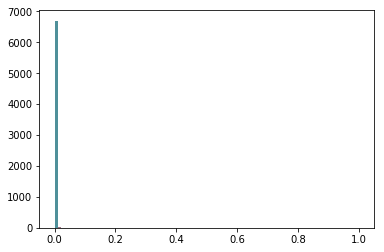

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'chili powder' 'sour cream' 'ground cumin' 'onions' 'salsa'
 'garlic'] [0.03153724 0.03077508 0.02848218 0.0263752  0.02363897 0.02068425
 0.0196772 ]
Latent recipe 2 : ['olive oil' 'salt' 'garlic' 'grated parmesan cheese' 'onions' 'pepper'
 'dried oregano'] [0.04910262 0.04632918 0.0405223  0.03895555 0.03241682 0.03190586
 0.01741185]
Latent recipe 3 : ['salt' 'onions' 'ground cumin' 'garlic' 'ground turmeric' 'water'
 'garam masala'] [0.04845298 0.04080242 0.02393153 0.02246565 0.02158308 0.02143772
 0.0210373 ]
Latent recipe 4 : ['salt' 'olive oil' 'garlic cloves' 'cooking spray' 'ground black pepper'
 'purple onion' 'fresh lemon juice'] [0.06463317 0.0559286  0.03921562 0.03742962 0.02411551 0.02320975
 0.02226331]
Latent recipe 5 : ['onions' 'salt' 'water' 'carrots' 'garlic' 'pepper' 'ground black pepper'] [0.05498463 0.04564166 0.02873751 0.02634772 0.02532141 0.02009886
 0.01807529]
Latent recipe 6 : ['sugar' '

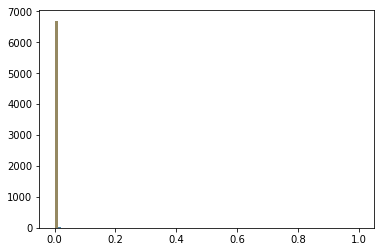

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'onions' 'green chilies' 'cumin seed' 'garam masala' 'oil'
 'ground turmeric'] [0.05491767 0.0437082  0.03288911 0.0308902  0.0298577  0.02717738
 0.02645736]
Latent recipe 2 : ['sugar' 'vanilla extract' 'butter' 'water' 'ground cinnamon' 'salt'
 'granulated sugar'] [0.06475524 0.04110896 0.0289538  0.02372737 0.02263532 0.02240807
 0.0173194 ]
Latent recipe 3 : ['salt' 'pepper' 'onions' 'oil' 'water' 'garlic' 'eggs'] [0.08529896 0.06918805 0.05479131 0.0383952  0.03673572 0.03497609
 0.02872085]
Latent recipe 4 : ['fish sauce' 'lime' 'coconut milk' 'sugar' 'shallots' 'fresh lime juice'
 'lime juice'] [0.0559481  0.02997529 0.02737541 0.02484596 0.02433247 0.02279429
 0.01948205]
Latent recipe 5 : ['olive oil' 'extra-virgin olive oil' 'salt' 'garlic cloves'
 'ground black pepper' 'garlic' 'fresh lemon juice'] [0.06368078 0.04520176 0.04315957 0.03419943 0.02710703 0.01899621
 0.01893123]
Latent recipe 6 : ['salt' 'grou

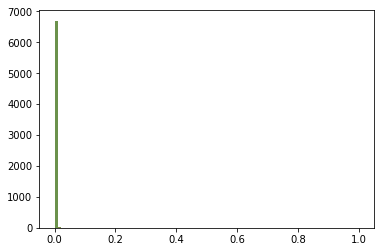

Top ingredients for each "latent recipe":
Latent recipe 1 : ['ground cumin' 'salt' 'garlic cloves' 'olive oil' 'onions' 'kosher salt'
 'ground black pepper'] [0.03693866 0.0339546  0.03080856 0.02766504 0.02100285 0.02047612
 0.02011996]
Latent recipe 2 : ['onions' 'salt' 'carrots' 'water' 'garlic' 'pepper' 'olive oil'] [0.06035998 0.04823395 0.03141851 0.02849334 0.02792449 0.02450109
 0.02255081]
Latent recipe 3 : ['soy sauce' 'sugar' 'garlic' 'sesame oil' 'water' 'green onions' 'salt'] [0.04644854 0.028839   0.02782852 0.02498632 0.02246183 0.02146197
 0.02088936]
Latent recipe 4 : ['ground beef' 'sour cream' 'shredded cheddar cheese' 'mayonaise'
 'green onions' 'worcestershire sauce' 'onions'] [0.03627417 0.03575383 0.03153011 0.0288903  0.02818495 0.02246142
 0.0217994 ]
Latent recipe 5 : ['lemon' 'orange' 'sugar' 'orange juice' 'fine sea salt' 'water'
 'sea salt'] [0.10350179 0.03387996 0.032319   0.03225789 0.02720086 0.02069983
 0.02019216]
Latent recipe 6 : ['large eggs' 'unsa

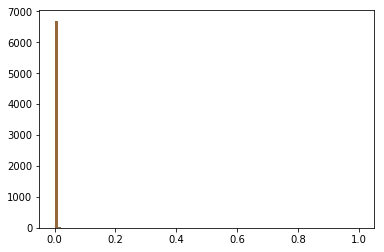

Top ingredients for each "latent recipe":
Latent recipe 1 : ['olive oil' 'garlic' 'salt' 'onions' 'ground black pepper'
 'dried oregano' 'tomato paste'] [0.0698225  0.05433102 0.05051927 0.04436304 0.03232487 0.02888305
 0.0225099 ]
Latent recipe 2 : ['butter' 'sugar' 'ground cinnamon' 'brown sugar' 'eggs' 'vanilla extract'
 'white sugar'] [0.06229698 0.03978653 0.03787917 0.02752482 0.02634452 0.02540737
 0.02477574]
Latent recipe 3 : ['soy sauce' 'sesame oil' 'sugar' 'garlic' 'water' 'corn starch'
 'green onions'] [0.06237601 0.03572133 0.03020598 0.0281401  0.02639607 0.02615945
 0.02595481]
Latent recipe 4 : ['butter' 'olive oil' 'dry white wine' 'salt' 'shallots' 'unsalted butter'
 'garlic cloves'] [0.05080618 0.04549656 0.04416204 0.04336328 0.02631812 0.02402219
 0.02228859]
Latent recipe 5 : ['fish sauce' 'sugar' 'fresh lime juice' 'coconut milk' 'garlic' 'lime'
 'water'] [0.04292119 0.02494049 0.02384969 0.02095359 0.02059512 0.0203348
 0.01759152]
Latent recipe 6 : ['onions' 

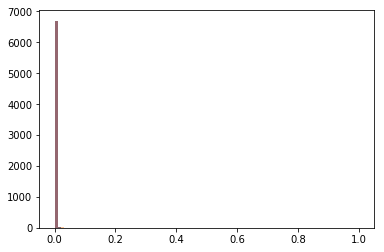

Top ingredients for each "latent recipe":
Latent recipe 1 : ['fish sauce' 'sugar' 'garlic' 'coconut milk' 'fresh lime juice'
 'shallots' 'vegetable oil'] [0.04384512 0.02536049 0.02137916 0.01988719 0.01931549 0.01875952
 0.01777995]
Latent recipe 2 : ['salt' 'cayenne pepper' 'paprika' 'garlic powder' 'onions'
 'worcestershire sauce' 'green bell pepper'] [0.03498292 0.03483038 0.03318052 0.02975336 0.02548264 0.02498361
 0.02450401]
Latent recipe 3 : ['salt' 'onions' 'water' 'pepper' 'garlic' 'potatoes' 'carrots'] [0.09208356 0.09181725 0.06597459 0.06264623 0.03386475 0.03310963
 0.02653267]
Latent recipe 4 : ['sugar' 'cucumber' 'water' 'salt' 'lemon juice' 'lemon' 'fresh mint'] [0.05082741 0.03457919 0.03387263 0.02578703 0.02442665 0.02175433
 0.01729453]
Latent recipe 5 : ['unsalted butter' 'salt' 'ground black pepper' 'olive oil' 'butter'
 'garlic cloves' 'dry white wine'] [0.04823365 0.0346638  0.02779016 0.02775443 0.02735112 0.02545089
 0.02478838]
Latent recipe 6 : ['soy sauce

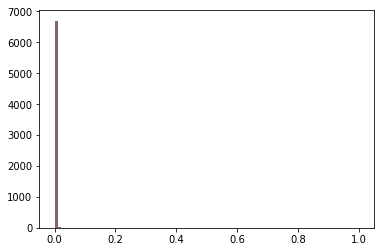

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'onions' 'pepper' 'carrots' 'eggs' 'water' 'potatoes'] [0.07453963 0.07425155 0.05242858 0.04948413 0.04859026 0.0335476
 0.02800432]
Latent recipe 2 : ['water' 'cumin seed' 'salt' 'onions' 'black peppercorns' 'vegetable oil'
 'clove'] [0.03838619 0.0347258  0.0287956  0.02820892 0.02777585 0.02467858
 0.02128746]
Latent recipe 3 : ['soy sauce' 'sesame oil' 'garlic' 'corn starch' 'green onions' 'sugar'
 'water'] [0.06504883 0.03735272 0.03627477 0.03467863 0.02743344 0.02641467
 0.02624813]
Latent recipe 4 : ['scallions' 'soy sauce' 'mirin' 'rice vinegar' 'sugar' 'sesame seeds'
 'sake'] [0.05276091 0.04844686 0.03775367 0.03535412 0.03418834 0.02692371
 0.02589613]
Latent recipe 5 : ['salt' 'onions' 'green bell pepper' 'garlic' 'cayenne pepper'
 'garlic powder' 'dried thyme'] [0.04547802 0.03559158 0.02595176 0.02261624 0.02256228 0.02246499
 0.02071044]
Latent recipe 6 : ['salt' 'sugar' 'all-purpose flour' 'baking pow

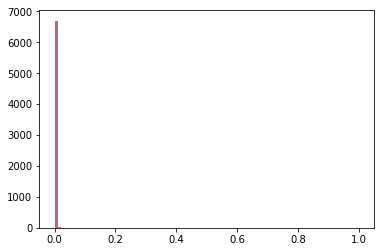

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'onions' 'oil' 'cumin seed' 'water' 'ground turmeric'
 'garam masala'] [0.05799223 0.04350082 0.03611031 0.03549047 0.02653847 0.02604159
 0.02598025]
Latent recipe 2 : ['ground cumin' 'olive oil' 'salt' 'onions' 'ground coriander' 'garlic'
 'cayenne pepper'] [0.0402633  0.03547641 0.03479094 0.0297167  0.0268411  0.02671347
 0.0211099 ]
Latent recipe 3 : ['extra-virgin olive oil' 'purple onion' 'fresh lemon juice' 'salt'
 'olive oil' 'garlic cloves' 'red wine vinegar'] [0.05983237 0.05652779 0.04991208 0.0430393  0.04056221 0.03743919
 0.0361161 ]
Latent recipe 4 : ['salt' 'butter' 'garlic powder' 'pepper' 'paprika' 'ground black pepper'
 'mayonaise'] [0.055842   0.04773372 0.04303858 0.03209129 0.02548053 0.02426734
 0.02204274]
Latent recipe 5 : ['salt' 'olive oil' 'potatoes' 'onions' 'carrots' 'pepper' 'butter'] [0.066515   0.04156443 0.03844854 0.03818783 0.0290829  0.02714705
 0.02667902]
Latent recipe 6 : ['soy 

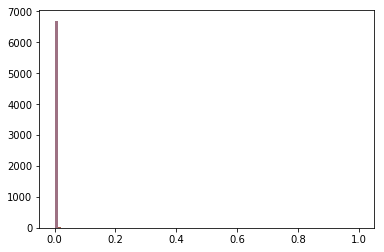

Top ingredients for each "latent recipe":
Latent recipe 1 : ['butter' 'salt' 'fresh parsley' 'olive oil' 'pepper' 'garlic'
 'grated parmesan cheese'] [0.07258716 0.05703098 0.03717569 0.03583905 0.03447252 0.03025794
 0.02510192]
Latent recipe 2 : ['garlic powder' 'mayonaise' 'cayenne pepper' 'paprika' 'salt'
 'ground black pepper' 'worcestershire sauce'] [0.05404248 0.05048879 0.04616376 0.04081248 0.03712662 0.0364435
 0.03130646]
Latent recipe 3 : ['fish sauce' 'lime' 'coconut milk' 'shallots' 'lime juice' 'garlic'
 'lemongrass'] [0.04951419 0.04235595 0.03737868 0.02907103 0.02782765 0.02304032
 0.02032952]
Latent recipe 4 : ['large eggs' 'all-purpose flour' 'salt' 'unsalted butter' 'baking powder'
 'buttermilk' 'sugar'] [0.12814552 0.11913325 0.09024613 0.05838565 0.05672315 0.04506854
 0.04218187]
Latent recipe 5 : ['soy sauce' 'rice vinegar' 'carrots' 'sugar' 'scallions' 'green onions'
 'water'] [0.03945195 0.03166699 0.03109434 0.03061805 0.02963935 0.02365683
 0.02197871]
Late

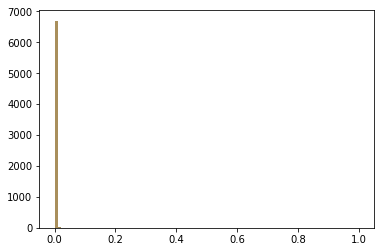

Top ingredients for each "latent recipe":
Latent recipe 1 : ['garlic powder' 'salt' 'paprika' 'cayenne pepper' 'onion powder'
 'black pepper' 'ground black pepper'] [0.12089531 0.06398569 0.060495   0.05397806 0.04426959 0.03014432
 0.02836126]
Latent recipe 2 : ['butter' 'pepper' 'salt' 'onions' 'eggs' 'chicken broth' 'olive oil'] [0.09850543 0.09495575 0.09438608 0.0458203  0.03170118 0.02984613
 0.02953286]
Latent recipe 3 : ['sour cream' 'salsa' 'shredded cheddar cheese' 'flour tortillas'
 'chili powder' 'black beans' 'green onions'] [0.06317975 0.04363281 0.03484329 0.03379997 0.02647138 0.02561792
 0.02250705]
Latent recipe 4 : ['mayonaise' 'worcestershire sauce' 'cracked black pepper' 'dijon mustard'
 'hot sauce' 'cider vinegar' 'lemon juice'] [0.07901674 0.04489874 0.03061512 0.02957088 0.02890553 0.02783429
 0.02767597]
Latent recipe 5 : ['garlic cloves' 'olive oil' 'extra-virgin olive oil' 'salt'
 'ground black pepper' 'dry white wine' 'fresh lemon juice'] [0.04960216 0.04843

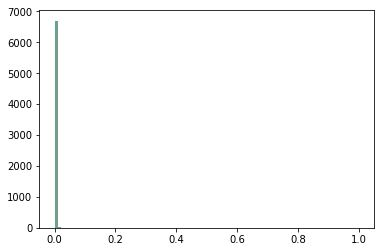

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'oil' 'onions' 'cumin seed' 'green chilies' 'water' 'clove'] [0.06313248 0.05828833 0.04009039 0.03619277 0.0322043  0.02610341
 0.02562842]
Latent recipe 2 : ['sugar' 'water' 'cider vinegar' 'cold water' 'fresh lemon juice'
 'orange juice' 'strawberries'] [0.18343974 0.05050823 0.01975311 0.01928139 0.01753385 0.01647755
 0.01593126]
Latent recipe 3 : ['peeled fresh ginger' 'garlic cloves' 'chopped cilantro fresh'
 'sliced green onions' 'fresh lime juice' 'water' 'salt'] [0.05345174 0.03601122 0.03147586 0.0310976  0.02934729 0.02720698
 0.02352116]
Latent recipe 4 : ['extra-virgin olive oil' 'fresh lemon juice' 'olive oil' 'garlic cloves'
 'dry white wine' 'flat leaf parsley' 'salt'] [0.06112424 0.05317643 0.04890004 0.04757052 0.04013306 0.03297338
 0.03170348]
Latent recipe 5 : ['salt' 'sugar' 'all-purpose flour' 'baking powder' 'butter'
 'vanilla extract' 'large eggs'] [0.06158889 0.05761847 0.05289849 0.03944549 

In [15]:
for NComponents in np.arange(1,20)+1:

    print('N component =', NComponents)

    # load in BMF results
    latentRecipes = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_latentRecipes.csv', header=None, index_col=False).values # pseudo counts
    latentRecipes = latentRecipes/np.sum(latentRecipes,axis=1)[:,np.newaxis] # feature weights
    recipeProportionsfromLatentRecipes = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_recipeProportionsfromLatentRecipes.csv', header=None, index_col=False).values

    # histogram of feature weights for each "latent recipe"
    for i in range(NComponents):
        sns.distplot(latentRecipes[i,:], bins=np.linspace(0,1,101), label=i, kde=False)
    plt.show()

    # top ingredients for each "latent recipe"
    print('Top ingredients for each "latent recipe":')
    for i in range(NComponents):
        topIndices = np.where((latentRecipes[i,:] > np.percentile(latentRecipes[i,:], 99.9)))[0] #&(latentRecipes[i,:] > 0.1)
        topIndices = topIndices[np.argsort(-latentRecipes[i, topIndices])]
        print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], latentRecipes[i, topIndices]) #, latentRecipes[i, topIndices]
    
    print('')

In [ ]:
for NComponents in np.arange(1,20)+1:

    print('N component =', NComponents)

    # load in BMF results
    latentRecipes200 = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_latentRecipes_maxIter200.csv', header=None, index_col=False).values # pseudo counts
    latentRecipes200 = latentRecipes200/np.sum(latentRecipes200,axis=1)[:,np.newaxis] # feature weights
    recipeProportionsfromLatentRecipes200 = pd.read_csv('LDAresults/NComponents'+str(NComponents)+'_recipeProportionsfromLatentRecipes_maxIter200.csv', header=None, index_col=False).values

    # histogram of feature weights for each "latent recipe"
    for i in range(NComponents):
        sns.distplot(latentRecipes200[i,:], bins=np.linspace(0,1,101), label=i, kde=False)
    plt.show()

    # top ingredients for each "latent recipe"
    print('Top ingredients for each "latent recipe":')
    for i in range(NComponents):
        topIndices = np.where((latentRecipes200[i,:] > np.percentile(latentRecipes200[i,:], 99.9)))[0] #&(latentRecipes[i,:] > 0.1)
        topIndices = topIndices[np.argsort(-latentRecipes200[i, topIndices])]
        print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], latentRecipes200[i, topIndices]) #, latentRecipes[i, topIndices]
    
    print('')